# first keras model on imdb with pre-trained word embeddings

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import keras
# from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

# import warnings
# warnings.filterwarnings('ignore')

/home/kuldeep.singh/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_movie_data = "/data/users-workspace/kuldeep_data/movie_data.csv"
df = pd.read_csv(path_to_movie_data)
df.head()

,review,sentiment
0,Usually I love Lesbian movies even when they a...,0.0
1,Prix de Beauté was made on the cusp of the cha...,1.0
2,This lasted several years despite the late hou...,1.0
3,This is 2009 and this way underrated gem has l...,1.0
4,John Waters has given us a genuinely enjoyable...,1.0


In [3]:
texts = df.review
print type(texts)

labels = df.sentiment
print type(labels)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [4]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 400

In [5]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

50000


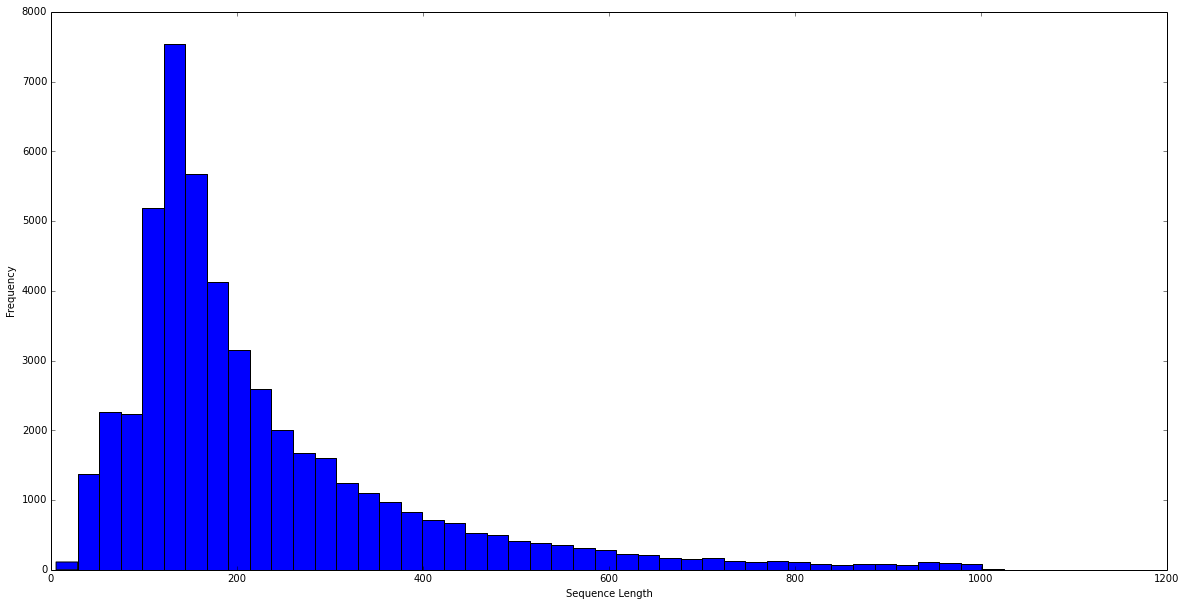

In [6]:
lenList = []
for d in sequences:
    counter = len(d)
    lenList.append(counter)
print len(lenList)

#print lenList[:10]
plt.figure(figsize=(20,10))
plt.hist(lenList, 100)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

In [7]:
WORD_INDEX = tokenizer.word_index
print "Found %i unique tokens." %len(WORD_INDEX) # ????

Found 124259 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
one_hot_encoder = OneHotEncoder(sparse=False)
labels_ = one_hot_encoder.fit_transform(labels.reshape(-1, 1))
type(labels_)

/home/kuldeep.singh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


numpy.ndarray

In [10]:
print "shape of data tensor: ", data.shape
print "shape of label tensor: ", labels_.shape

shape of data tensor:  (50000, 400)
shape of label tensor:  (50000, 2)


In [11]:
# splitting into train and test 
indices = range(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_ = labels_[indices]

In [12]:
x_train = data[:20000]
y_train = labels_[:20000]

x_val = data[20000: 25000]
y_val = labels_[20000: 25000]

x_test = data[25000: 30000]
y_test = labels_[25000: 30000]

In [13]:
embeddings_index = {}
GLOVE_DIR = "/data/users-workspace/kuldeep_data/glove/"
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [14]:
EMBEDDING_DIMENSION = 300
EMBEDDING_MATRIX = np.zeros((len(WORD_INDEX) +1, EMBEDDING_DIMENSION))

for word, i in WORD_INDEX.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[i] = embedding_vector

In [15]:
embedding_layer = Embedding(len(WORD_INDEX) + 1,
                           EMBEDDING_DIMENSION,
                           weights=[EMBEDDING_MATRIX],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False)

In [26]:
def create_model():
    
    _input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    
    embedded_sequences = embedding_layer(_input)

    x = Conv1D(64, 8, activation='relu', padding="same")(embedded_sequences)
    x = MaxPooling1D(2, padding="same")(x)
    x = Dropout(rate=0.5)(x)
    x = Conv1D(64, 4, activation='relu', padding="same")(x)
    x = MaxPooling1D(2,padding="same")(x)
    x = Dropout(rate=0.5)(x)
    x = Conv1D(32, 4, activation='relu', padding="same")(x)
#     x = GlobalMaxPooling1D()(x)
    x = MaxPooling1D(2, padding="same")(x)  
    
    x = Conv1D(32, 4, activation='relu', padding="same")(x)
    x = MaxPooling1D(2, padding="same")(x)
    x = Dropout(rate=0.5)(x)
    
    x = Flatten()(x)
#     x = Dropout(rate=0.4)(x)
    x = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(rate=0.5)(x)
    _outputs = Dense(2, activation='softmax')(x)

    model = Model(_input, _outputs)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



In [27]:
# happy learning!
model = create_model()
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 96s 5ms/step - loss: 1.1700 - acc: 0.5092 - val_loss: 0.7553 - val_acc: 0.5480
Epoch 2/20
20000/20000 [==============================] - 82s 4ms/step - loss: 0.5730 - acc: 0.7289 - val_loss: 0.4105 - val_acc: 0.8448
Epoch 3/20
20000/20000 [==============================] - 100s 5ms/step - loss: 0.4196 - acc: 0.8334 - val_loss: 0.3653 - val_acc: 0.8586
Epoch 4/20
20000/20000 [==============================] - 108s 5ms/step - loss: 0.3718 - acc: 0.8605 - val_loss: 0.3486 - val_acc: 0.8776
Epoch 5/20
20000/20000 [==============================] - 103s 5ms/step - loss: 0.3472 - acc: 0.8713 - val_loss: 0.3465 - val_acc: 0.8766
Epoch 6/20
20000/20000 [==============================] - 105s 5ms/step - loss: 0.3272 - acc: 0.8815 - val_loss: 0.3204 - val_acc: 0.8878
Epoch 7/20
20000/20000 [==============================] - 101s 5ms/step - loss: 0.3142 - acc: 0.8873 - val_loss: 0.3249 - val

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 300)          37278000  
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 400, 128)          153728    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 200, 128)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 200, 128)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 200, 64)           16448     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 100, 64)           0         
__________

In [31]:
# defining model function 
def setup_model():
    
    _input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    
    embedded_sequences = embedding_layer(_input)

    
    x = Conv1D(128, 4, activation='relu', padding="same")(embedded_sequences)
    x = MaxPooling1D(2, padding="same", strides=1)(x)
    x = Dropout(rate=0.5)(x)
    x = Conv1D(64, 2, activation='relu', padding="same")(x)
    x = MaxPooling1D(2, padding="same", strides=1)(x)
    x = Dropout(rate=0.5)(x)
#     x = Conv1D(128, 5, activation='relu')(x)
#     x = MaxPooling1D(5)(x)
#     x = Dropout(rate=0.2)(x)
#     x = Flatten()(x)

    x = LSTM(128, return_sequences=True, dropout=0.4, kernel_regularizer=regularizers.l2(0.03))(x)
#     x = Dropout(rate=0.5)(x)
    x = LSTM(128, dropout=0.4, kernel_regularizer=regularizers.l2(0.03))(x)
#     x = Dropout(rate=0.5)(x)
    
    _output = Dense(2, activation="sigmoid")(x)
    
    model = Model(inputs=_input, outputs=_output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = setup_model()
model.fit(x_train, y_train, epochs=20, batch_size=128,  validation_data=(x_val, y_val)) #,
#           callbacks=[TensorBoard(log_dir='/data/users-workspace/kuldeep_data/tensorflow_logs/keras_imdb_1'),
#                      early_stop])


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 444s 22ms/step - loss: 2.3382 - acc: 0.6628 - val_loss: 0.5529 - val_acc: 0.8022
Epoch 2/20
10112/20000 [==============>...............] - ETA: 3:01 - loss: 0.5681 - acc: 0.7537

In [141]:
batch_size = 128
score, acc = model.evaluate(x_train[:5000], y_train[:5000], batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(x_val, y_val, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


5000/5000 [==============================] - 38s 8ms/step
('Train score:', 0.04585642672777176)
('Train accuracy:', 0.9915)
5000/5000 [==============================] - 38s 8ms/step
('Test score:', 0.3417934672564268)
('Test accuracy:', 0.892)
